<a href="https://colab.research.google.com/github/SEHWAJO/MyProject/blob/main/%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D_%EB%B6%84%EB%A5%98_%EB%AA%A8%EB%8D%B8_%EB%A7%8C%EB%93%A4%EA%B8%B0_%26_%ED%8F%89%EA%B0%80_%EC%97%B0%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Applied Predictive Modeling

 이번 스프린트 챌린지에서는 시카고에 있는 식당들의 정보와 해당 식당들의 위생 검사 결과에 관한 정보를 담은 데이터셋을 다루게 됩니다.

데이터셋에 관한 설명은 [PDF 문서](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF)를 참고해주시길 바랍니다.

#### 목표: 오늘 여러분은 Chicago시의 공중보건부에서 진행한 레스토랑들의 위생 검사 "불합격" 여부를 예측하는 모델을 만들어야 합니다.

여러분의 모델이 예측할 target은 `Inspection Fail` 칼럼입니다.   
칼럼 값은 아래와 같습니다:
- 식당이 위생 검사에 불합격한 경우: **1**
- 식당이 검사를 통과한 경우: **0**

In [1]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap

In [ ]:
# 데이터셋을 불러오기 위해 판다스 라이브러리를 불러옵니다
import pandas as pd

train_url = 'https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/food_inspection_sc23x/food_ins_train.csv'
test_url  = 'https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/food_inspection_sc23x/food_ins_test.csv'

# train, test 데이터셋을 불러옵니다
train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

# 데이터셋 확인
assert train.shape == (60000, 17)
assert test.shape  == (20000, 17)

# Part 1: 데이터 전처리 (Data Preprocessing)

In [ ]:
## 1.1 데이터셋을 파악하기 위한 EDA를 진행하세요
> EDA를 하는 방식 및 라이브러리에 대한 제한은 없습니다. 단, **시간 분배**에 주의하세요.

## 컬럼 설명

- DBA: 설립 시 서류에 등록한 이름

- AKA: 대중들에게 알려져 있는 상표 이름

- License number: 사업자 고유번호 (한국으로 치면 사업자등록번호)

- Type of facility: 매장 업종 

    bakery, banquet hall, candy store, caterer, coffee shop, day care center (for ages less than 2), day care center (for ages 2 – 6), day care center (combo, for ages less than 2 and 2-6 combined), gas station, Golden Diner, grocery store, hospital, long term care center(nursing home), liquor store, mobile food dispenser, restaurant, paleteria, school, shelter, tavern, social club, wholesaler, or Wrigley Field Rooftop.
    
- Risk category of facility: 위험 시설 분류 카테고리 : 국민 건강에 악영향을 미칠 위험으로 분류됩니다. 1이 가장 높고, 3이 가장 낮은 카테고리. (위험 1 시설이 검사 빈도가 높은 편이고, 위험 3 시설이 검사 빈도가 낮은 편입니다.)

- Street address, city, state and zip code of facility: 해당 시설이 위치한 주소 (Full Address)

- Inspection date: 검사 날짜. (어떤 사업장은 동일한 사업장명에 각기 다른 검사 날짜를 가지고 있을 수도 있습니다.)

- Inspection type: 검사 유형. 대부분의 유형에 대해 재검사를실시할 수 있으며, 다음과 같이 표시됩니다.
    - 캔버스 : 시설의 위험도와 관련된 가장 이란적인 유형의 검사. 
    - 협의 : 개업 전 소유자의 요청으로 검사를 수행.
    - 불만 접수 : 민원 사항 발생 시 검사를 수행할 때.
    - 면허 : 사업장의 영업허가서 발금 요건으로 검사를 할 때.
    - 식중독 의심 : 사업장에서 식사 (민원 처리 된 특정 유형의 검사)로 인해 병에 걸렸다고 주장하는 1인 이상에게 검사를 할 때.
    - 태스크포스 검사 : 술집 또는 주점의 검사가 수행된 경우
    
- Results: 검사 결과. 통과 / 조건부 합격 / 실패 
    - '합격'을 받는 사업장은 중대하거나 심각한 위반이없는 것으로 확인되었습니다. (각각 1-14번, 15-29번)
    - '조건부 합격'을 받은 업소는 위반사항이 중대하거나 심각한 것으로 조사되었으나, 이는 점검과정에서 시정되었습니다.
    - '실패'를 받은 업소는 검사 중 시정할 수 없는 중대 또는 중대 위반 사항이 있는 것으로 확인되었습니다.
    - 시설에서 실패를 받는다고 해서 반드시 사업장 면허가 정지되는 것은 아닙니다.
    - 폐업했거나 소재하지 않은 업소도 동일하게 표시됩니다.
    
- Violations: 위반사항. 설립자는 45개 이상의 고유 위반 번호 (위반번호 1-44 및 70)을 받을 수 있습니다. 열거된 각 위반번호에 대하여 위반 사항을 발행하기 된 소견 및 해당 업소가 시정해야 하는 요건에 대한 구체적인 설명이 이어집니다.

In [ ]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install eli5

     |████████████████████████████████| 106 kB 1.1 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install pdpbox

     |████████████████████████████████| 34.0 MB 1.4 MB/s eta 0:00:01
     |████████████████████████████████| 37.8 MB 31.8 MB/s eta 0:00:01
  Created wheel for pdpbox: filename=PDPbox-0.2.1-py3-none-any.whl size=35758226 sha256=65e080b4a3292db264128bb5db5223e2cf61c74c4c0905daf197f7a289f02360
  Stored in directory: /Users/miaepark/Library/Caches/pip/wheels/35/fb/ef/a08dd2a1611435285fa3f9d9104bf554f10c2eb7293b526ccb
  Created wheel for matplotlib: filename=matplotlib-3.1.1-cp38-cp38-macosx_10_9_x86_64.whl size=8464408 sha256=16f85b867094c296dc56f249d4cc66c9d228d1b69ea8afad805d60e06bb0b043
  Stored in directory: /Users/miaepark/Library/Caches/pip/wheels/85/86/f1/054e7477b5e68f3c4a1258d12ae1c2205d6889283ce631dfe5
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1316 sha256=783dd36f57e406de34e6568693bea97d2470b15cc61495552a28bf3f14cf70c2
  Stored in directory: /Users/miaepark/Library/Caches/pip/wheels/22/0b/40/fd3f795caaa1fb4c6cb738bc1f56100be1e57da95849bfc897
Succ

In [ ]:
# analysis
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn.model_selection
from sklearn.model_selection import train_test_split

# pipeline
from sklearn.pipeline import make_pipeline

# encoding
from category_encoders import TargetEncoder, OrdinalEncoder

# Imputing
from sklearn.impute import SimpleImputer, KNNImputer

# model
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier 

# metrics
from sklearn.metrics import f1_score, roc_auc_score, classification_report, roc_curve

# hyperparameter Tunning
from sklearn.model_selection import RandomizedSearchCV

# Visualization
import eli5
from eli5.sklearn import PermutationImportance
import shap
from pdpbox.pdp import pdp_isolate, pdp_plot

In [ ]:
# 데이터 프레임 살펴보기 - train
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Inspection ID    60000 non-null  int64  
 1   DBA Name         60000 non-null  object 
 2   AKA Name         59283 non-null  object 
 3   License #        59996 non-null  float64
 4   Facility Type    58573 non-null  object 
 5   Risk             59976 non-null  object 
 6   Address          60000 non-null  object 
 7   City             59955 non-null  object 
 8   State            59985 non-null  object 
 9   Zip              59987 non-null  float64
 10  Inspection Date  60000 non-null  object 
 11  Inspection Type  60000 non-null  object 
 12  Violations       44130 non-null  object 
 13  Latitude         59822 non-null  float64
 14  Longitude        59822 non-null  float64
 15  Location         59822 non-null  object 
 16  Inspection Fail  60000 non-null  int64  
dtypes: float64(4

In [ ]:
# 데이터 프레임 살펴보기 - test
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Inspection ID    20000 non-null  int64  
 1   DBA Name         20000 non-null  object 
 2   AKA Name         19765 non-null  object 
 3   License #        20000 non-null  float64
 4   Facility Type    19548 non-null  object 
 5   Risk             19998 non-null  object 
 6   Address          20000 non-null  object 
 7   City             19989 non-null  object 
 8   State            19997 non-null  object 
 9   Zip              19996 non-null  float64
 10  Inspection Date  20000 non-null  object 
 11  Inspection Type  20000 non-null  object 
 12  Violations       14664 non-null  object 
 13  Latitude         19940 non-null  float64
 14  Longitude        19940 non-null  float64
 15  Location         19940 non-null  object 
 16  Inspection Fail  20000 non-null  int64  
dtypes: float64(4

In [ ]:
# 컬럼 살펴보기 - train
train_col = train.columns
print("train set features 개수:",len(train_col))
print(train_col)

train set features 개수: 17
Index(['Inspection ID', 'DBA Name', 'AKA Name', 'License #', 'Facility Type',
       'Risk', 'Address', 'City', 'State', 'Zip', 'Inspection Date',
       'Inspection Type', 'Violations', 'Latitude', 'Longitude', 'Location',
       'Inspection Fail'],
      dtype='object')


In [ ]:
# 컬럼 살펴보기 - test
test_col = train.columns
print("train set features 개수:",len(test_col))
print(test_col)

train set features 개수: 17
Index(['Inspection ID', 'DBA Name', 'AKA Name', 'License #', 'Facility Type',
       'Risk', 'Address', 'City', 'State', 'Zip', 'Inspection Date',
       'Inspection Type', 'Violations', 'Latitude', 'Longitude', 'Location',
       'Inspection Fail'],
      dtype='object')


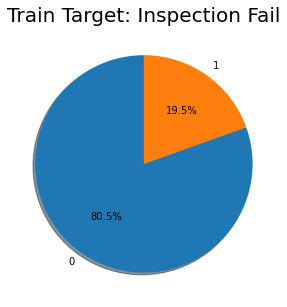

In [ ]:
# target 확인 - train
plt.subplots(figsize = (5,5))
plt.pie(train['Inspection Fail'].value_counts(), labels = train['Inspection Fail'].value_counts().index, 
        autopct="%.1f%%", shadow = True, startangle = 90)
plt.title('Train Target: Inspection Fail', size=20)
plt.show()

# imbalanced target. 검증 데이터 분할 시 주의해야 합니다.

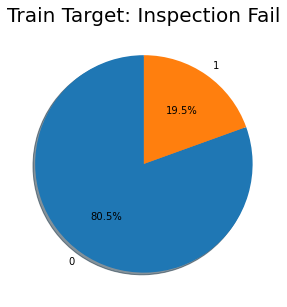

In [ ]:
# target 확인 - test
plt.subplots(figsize = (5,5))
plt.pie(test['Inspection Fail'].value_counts(), labels = test['Inspection Fail'].value_counts().index, 
        autopct="%.1f%%", shadow = True, startangle = 90)
plt.title('Train Target: Inspection Fail', size=20)
plt.show()

In [ ]:
# 결측치 확인
train.isnull().sum()

# Facility type, Violations 의 결측치를 잘 처리해야 합니다.
# AKA Name도 결측치가 많지만, 대신 DBA가 결측치가 없으므로 DBA를 사용합니다.

Inspection ID          0
DBA Name               0
AKA Name             717
License #              4
Facility Type       1427
Risk                  24
Address                0
City                  45
State                 15
Zip                   13
Inspection Date        0
Inspection Type        0
Violations         15870
Latitude             178
Longitude            178
Location             178
Inspection Fail        0
dtype: int64

In [ ]:
test.isnull().sum()

Inspection ID         0
DBA Name              0
AKA Name            235
License #             0
Facility Type       452
Risk                  2
Address               0
City                 11
State                 3
Zip                   4
Inspection Date       0
Inspection Type       0
Violations         5336
Latitude             60
Longitude            60
Location             60
Inspection Fail       0
dtype: int64

In [ ]:
# 중복값 확인
train.duplicated().sum(), test.duplicated().sum()

(0, 0)

In [ ]:
# Cardinality 확인
train.describe(include="all").T.sort_values("unique", ascending=False)

# Violations, AKA Name, Facility Type, Inspection Type의 cardinality를 잘 처리해야 함.

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Violations,44130,44035,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DBA Name,60000,20175,SUBWAY,830,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AKA Name,59283,19209,SUBWAY,1014,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Address,60000,15244,11601 W TOUHY AVE,755,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Location,59822,14533,"(-87.91442843927047, 42.008536400868735)",760,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Inspection Date,60000,2667,2013-11-14,57,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Facility Type,58573,366,Restaurant,39922,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Inspection Type,60000,55,Canvass,31913,NaN,NaN,NaN,NaN,NaN,NaN,NaN
City,59955,39,CHICAGO,59771,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Risk,59976,4,Risk 1 (High),42839,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
test.describe(include="all").T.sort_values("unique", ascending=False)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Violations,14664,14654,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DBA Name,20000,11690,SUBWAY,268,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AKA Name,19765,11222,SUBWAY,327,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Address,20000,10357,11601 W TOUHY AVE,250,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Location,19940,10074,"(-87.91442843927047, 42.008536400868735)",252,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Inspection Date,20000,2609,2016-03-18,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Facility Type,19548,215,Restaurant,13404,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Inspection Type,20000,33,Canvass,10673,NaN,NaN,NaN,NaN,NaN,NaN,NaN
City,19989,21,CHICAGO,19928,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Risk,19998,4,Risk 1 (High),14213,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 1.2 EDA의 결과를 토대로 Feature Engineering 및 Preprocessing을 진행하세요
> 새로운 feature를 만드는 작업뿐만이 아니라, 필요한 feature가 적절한 데이터 타입을 가지고 있지 않다면 변환합니다

In [ ]:
def eda_process(df):
    
    # 복사
    df_temp = df.copy()
    
    
    # State 컬럼 처리 : 결측치 및 IL이 아닌 row 삭제
    df_temp.dropna(subset=["State"], how="any", axis=0, inplace=True)
    df_temp = df_temp[df_temp["State"]=="IL"]
    
    
    # City 컬럼 처리 : Chicago가 맞는 곳과 아닌 곳으로 구분
    Chicago_list = ["CHICAGO", "312CHICAGO", "CHCICAGO","CHICAGO.", "CHICAGOI", "CHICAGOCHICAGO", "CCHICAGO"]
    df_temp["City"] = df_temp["City"].str.upper()
    df_temp["City_Chicago"] = [1 if i in Chicago_list else 0 for i in df_temp['City']]
    
    
    # Inspection date를 string에서 datetime으로 바꾼 후 연도, 월 추출
    df_temp["Inspection Date"] = train['Inspection Date'].apply(pd.to_datetime)
    df_temp["year"] = df_temp["Inspection Date"].dt.year
    df_temp["month"] = df_temp["Inspection Date"].dt.month
    
    
    # Cardinality 줄이기 1 : Facility type upper case > value_counts TOP10 이외는 etc로 처리
    df_temp["Facility Type"] = df_temp["Facility Type"].str.upper()
    facility_top10 = df_temp["Facility Type"].value_counts().sort_values(ascending=False).head(10).index.to_list()
    df_temp["Facility Type"] = [i if i in facility_top10 else "ETC" for i in df_temp['Facility Type']]
    
    
    # Cardinality 줄이기 2 : Inspection Type upper case > value_counts TOP10 이외는 etc로 처리
    df_temp["Inspection Type"] = df_temp["Inspection Type"].str.upper()
    inspection_top10 = df_temp["Inspection Type"].value_counts().sort_values(ascending=False).head(10).index.to_list()
    df_temp["Inspection Type"] = [i if i in inspection_top10 else "ETC" for i in df_temp["Inspection Type"]]
    
    
    # Cardinality 줄이기 3 : Violations 결측치 0으로 보완 > "|"으로 Split > len()을 사용하여 위반사항 "개수"로 변환
    df_temp["Violations"].fillna(0, inplace=True)
    df_temp["Violations"] = [0 if i == 0 else len(i.split("| ")) for i in df_temp["Violations"]]
    
    
    # Cardinality 줄이기 4 : License # > 결측치는 0, 고유번호가 있으면 1
    df_temp["License #"].fillna(0, inplace=True)
    df_temp["License"] = [0 if i == 0  else 1 for i in df_temp["License #"]]
    
    
    # Cardinality 줄이기  5 :
    df_temp["Name"] = df_temp["DBA Name"].str.upper()
    
    macdonald = set(df_temp["Name"][df_temp["Name"].str.contains("MCDONALD|MC DONALD'S|MC DONALDS")].values)
    df_temp.replace(macdonald, 'MCDONALDS', inplace=True)
    subways = set(df_temp["Name"][df_temp["Name"].str.contains("SUBWAY")].values)
    df_temp.replace(subways, 'SUBWAY', inplace=True)
    potbelly = set(df_temp["Name"][df_temp["Name"].str.contains("POTBELLY")].values)
    df_temp.replace(potbelly, 'POTBELLY SANDWICH WORKS', inplace=True)
    jimmy = set(df_temp["Name"][df_temp["Name"].str.contains("JIMMY JOHN")].values)
    df_temp.replace(jimmy, 'JIMMY JOHNS', inplace=True)
    dunkin_and_baskin = set(df_temp["Name"][df_temp["Name"].str.contains("DUNKIN DONUTS BASKIN ROBBINS|DUNKIN DONUTS/BASKIN ROBBINS|DUNKIN DONUTS / BASKIN ROBBINS")].values)
    df_temp.replace(dunkin_and_baskin, 'DUNKIN DONUTS/BASKIN ROBBINS', inplace=True)
    kfc = set(df_temp["Name"][df_temp["Name"].str.contains("KENTUCKY FRIED CHICKEN|KFC")].values)
    df_temp.replace(kfc, 'KFC', inplace=True)
    wendys = set(df_temp["Name"][df_temp["Name"].str.contains("WENDY")].values)
    df_temp.replace(wendys, "WENDYS", inplace=True)
    popeyes = set(df_temp["Name"][df_temp["Name"].str.contains("POPEYE")].values)
    df_temp.replace(popeyes, "POPEYES", inplace=True)
    domino = set(df_temp["Name"][df_temp["Name"].str.contains("DOMINO")].values)
    df_temp.replace(domino, "DOMINOS PIZZA", inplace=True)
    reggio = set(df_temp["Name"][df_temp["Name"].str.contains("REGGIO")].values)
    df_temp.replace(reggio, "REGGIOS PIZZA", inplace=True)
    seven = set(df_temp["Name"][df_temp["Name"].str.contains("ELEVEN")].values)
    df_temp.replace(seven, "7-ELEVEN", inplace=True)
    starbucks = set(df_temp["Name"][df_temp["Name"].str.contains("STARBUCKS")].values)
    df_temp.replace(starbucks, "STARBUCKS", inplace=True)
    papa = set(df_temp["Name"][df_temp["Name"].str.contains("PAPA JOHN")].values)
    df_temp.replace(papa, "PAPA JOHNS PIZZA", inplace=True)
    tacobell = set(df_temp["Name"][df_temp["Name"].str.contains("TACO BELL")].values)
    df_temp.replace(tacobell, "TACO BELL", inplace=True)
    wingstop = set(df_temp["Name"][df_temp["Name"].str.contains("WINGSTOP")].values)
    df_temp.replace(wingstop, "WINGSTOP", inplace=True)
    see = set(df_temp["Name"][df_temp["Name"].str.contains("SEE THRU CHINESE KITCHEN")].values)
    df_temp.replace(see, "SEE THRU CHINESE KITCHEN", inplace=True)
    harold = set(df_temp["Name"][df_temp["Name"].str.contains("HAROLD'S CHICKEN SHACK")].values)
    df_temp.replace(harold, "HAROLD'S CHICKEN SHACK", inplace=True)
    pizzahut = set(df_temp["Name"][df_temp["Name"].str.contains("PIZZA HUT")].values)
    df_temp.replace(pizzahut, "PIZZA HUT", inplace=True)
    chart = set(df_temp["Name"][df_temp["Name"].str.contains("CHARTWELLS")].values)
    df_temp.replace(chart, "CHARTWELLS", inplace=True)
    
    
    # Risk : 결측치 및 All 삭제 > 1, 2, 3으로 바꾸어 줌
    df_temp.dropna(subset=["Risk"], how="any", axis=0, inplace=True)
    df_temp.drop(df_temp.loc[df_temp['Risk']=='All'].index, inplace=True)
    df_temp.replace('Risk 1 (High)', 1, inplace=True)
    df_temp.replace('Risk 2 (Medium)', 2, inplace=True)
    df_temp.replace('Risk 3 (Low)', 3, inplace=True)
    
    
    # 필요한 features 선택
    features = ["Name", "year", "month", "License", "Facility Type", "City_Chicago", "Latitude", "Longitude",  
                "Risk", "Inspection Type", "Violations", "Inspection Fail"]
    feature = df_temp[features]
       
    
    return feature

In [ ]:
X_train = eda_process(train)
X_test = eda_process(test)

In [ ]:
X_train.shape, X_test.shape

((59947, 12), (19994, 12))

In [ ]:
X_train.head()

,Name,year,month,License,Facility Type,City_Chicago,Latitude,Longitude,Risk,Inspection Type,Violations,Inspection Fail
0,MY SWEET STATION INC,2017,5,1,RESTAURANT,1,41.927577,-87.651528,1,CANVASS,0,0
1,OUTTAKES,2017,8,1,RESTAURANT,1,41.881807,-87.629543,2,CANVASS,3,0
2,JAFFA BAGELS,2015,12,1,RESTAURANT,1,41.886377,-87.624382,1,COMPLAINT,3,0
3,FRANKS 'N' DAWGS,2012,7,1,RESTAURANT,1,41.914990,-87.654994,1,CANVASS,2,0
4,SOUTH COAST,2013,9,1,RESTAURANT,1,41.858996,-87.624106,1,CANVASS,0,0


In [ ]:
X_train["Inspection Fail"].value_counts()

0    48241
1    11706
Name: Inspection Fail, dtype: int64

# Part 2: 모델링 (Modeling)

## 2.1 검증 방식 (Cross-validation / Hold-out Validation)을 정한 후 데이터셋을 목적에 맞게 분할하세요

In [ ]:
# hold out validation으로 진행
from sklearn.model_selection import train_test_split

target = 'Inspection Fail'

X_train, X_val = train_test_split(X_train, test_size = 0.2, random_state = 2, stratify = X_train[target])


# features & target 분리
y_train = X_train[target]
X_train = X_train.drop(target, axis=1)

y_val = X_val[target]
X_val = X_val.drop(target, axis=1)

y_test = X_test[target]
X_test = X_test.drop(target, axis=1)

In [ ]:
X_train.shape, y_train.shape

((47957, 11), (47957,))

In [ ]:
X_train.head()

,Name,year,month,License,Facility Type,City_Chicago,Latitude,Longitude,Risk,Inspection Type,Violations
47615,LA FIESTA BAKERY,2015,6,1,RESTAURANT,1,41.776073,-87.722841,1,CANVASS,4
11086,"A.P. DELI RESTAURANT GROUP, INC.",2012,6,1,RESTAURANT,1,41.698170,-87.621024,1,CANVASS RE-INSPECTION,1
12676,MUNCHIEZ,2020,7,1,RESTAURANT,1,41.721035,-87.667629,2,LICENSE RE-INSPECTION,8
7503,ARANDA MEXICAN RESTAURANT,2018,1,1,RESTAURANT,1,41.938304,-87.793571,1,LICENSE,9
44414,FRESH MARKET PLACE,2019,2,1,GROCERY STORE,1,41.924273,-87.752115,1,COMPLAINT,14


In [ ]:
X_val.shape, y_val.shape

((11990, 11), (11990,))

In [ ]:
X_test.shape, y_test.shape

((19994, 11), (19994,))

## 2.2 모델 학습을 위한 파이프라인을 구축 후 학습(fit)까지 진행하세요
> 모델은 scikit-learn, xgboost, lightgbm 등 어떤 라이브러리를 사용하셔도 괜찮지만 특정 라이브러리는 **설치 및 설정에 시간이 소요되는 점**을 감안하시기 바랍니다

In [ ]:
ratio = 0.243523/0.756477

# pre process : encoding, Imputing
pre_process = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='median')
)

# fit_transform, transform
X_train_processed = pre_process.fit_transform(X_train)
X_val_processed = pre_process.transform(X_val)

# model
xgb_cf = XGBClassifier(
    n_estimators=1000, 
    verbosity=0,
    max_depth=7,        
    learning_rate=0.2,
    scale_pos_weight=ratio, 
    n_jobs=-1,
    random_state=2
)

# early stopping 
eval_set = [(X_train_processed, y_train), 
            (X_val_processed, y_val)]

# fit
xgb_cf.fit(X_train_processed, y_train, 
          eval_set=eval_set,
          eval_metric='auc',
          early_stopping_rounds=100
         ) # 10 rounds 동안 스코어의 개선이 없으면 멈춤

[0]	validation_0-auc:0.81931	validation_1-auc:0.82281
[1]	validation_0-auc:0.83047	validation_1-auc:0.83120
[2]	validation_0-auc:0.83226	validation_1-auc:0.82764
[3]	validation_0-auc:0.83774	validation_1-auc:0.83193
[4]	validation_0-auc:0.83975	validation_1-auc:0.83275
[5]	validation_0-auc:0.84095	validation_1-auc:0.83331
[6]	validation_0-auc:0.84301	validation_1-auc:0.83430
[7]	validation_0-auc:0.84539	validation_1-auc:0.83471
[8]	validation_0-auc:0.84678	validation_1-auc:0.83522
[9]	validation_0-auc:0.84858	validation_1-auc:0.83734
[10]	validation_0-auc:0.85009	validation_1-auc:0.83908
[11]	validation_0-auc:0.85225	validation_1-auc:0.84109
[12]	validation_0-auc:0.85359	validation_1-auc:0.84201
[13]	validation_0-auc:0.85492	validation_1-auc:0.84238
[14]	validation_0-auc:0.85624	validation_1-auc:0.84347
[15]	validation_0-auc:0.85797	validation_1-auc:0.84381
[16]	validation_0-auc:0.85943	validation_1-auc:0.84423
[17]	validation_0-auc:0.86111	validation_1-auc:0.84483
[18]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=-1, num_parallel_tree=1, random_state=2,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.3219172559112835,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=0)

## 2.3 테스트셋의 ROC / AUC 검증 점수를 예측합니다
> 제작한 모델을 활용해서 테스트셋의 **확률**을 예측하세요 (`ROC/AUC 검증 점수`를 **0.65 혹은 그 이상** 달성한다면 매우 훌륭한 모델입니다). 명시된 성능이 나오지 않았더라도 이 문제에 모든 시간을 소요하시면 안됩니다 (점수가 안나오는 경우 여러분이 구축한 파이프라인 모델링 및 모델링 과정으로 평가합니다)

In [ ]:
X_test_processed = pre_process.transform(X_test)
y_test_pred = xgb_cf.predict(X_test_processed)
y_test_pred_proba = xgb_cf.predict_proba(X_test_processed)[:, -1]

# AUC Score
print('AUC score: ', roc_auc_score(y_test, y_test_pred_proba))

AUC score:  0.8056020438426394


In [ ]:
# Classification report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.83      0.98      0.90     16096
           1       0.68      0.17      0.28      3898

    accuracy                           0.82     19994
   macro avg       0.76      0.58      0.59     19994
weighted avg       0.80      0.82      0.78     19994



In [ ]:
# plot ROC curve
lr_probs = xgb_cf.predict_proba(X_test_processed)
lr_probs = lr_probs[:,1]
lr_auc = roc_auc_score(y_test, lr_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

ns_probs = [0 for _ in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_probs)
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)

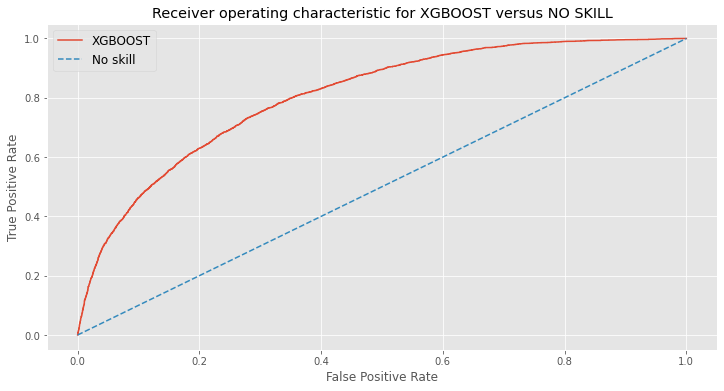

In [ ]:
from matplotlib import pyplot

plt.style.use('ggplot')
plt.subplots(figsize = (12,6))
pyplot.plot(lr_fpr, lr_tpr, label='XGBOOST')
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No skill')
pyplot.xlabel('False Positive Rate', size=12)
pyplot.ylabel('True Positive Rate', size=12)
pyplot.title('Receiver operating characteristic for XGBOOST versus NO SKILL')
pyplot.legend(prop={'size': 12})
pyplot.show()

## 2.4 하이퍼 파라미터 튜닝을 통해서 모델을 개선하세요
> `RandomSearchCV`, `GridSearchCV` 등을 활용해서 모델의 성능을 개선합니다. 범위 설정에 따라 시간이 매우 소요될 수 있습니다.

In [ ]:
# Hyperparams
dists = {
    'xgbclassifier__n_estimators': [100, 200, 500, 1000], 
    'xgbclassifier__max_depth': [3, 5, 7, 9], 
    'xgbclassifier__learning_rate' : [0.01, 0.05, 0.1, 0.15, 0.2],
    'xgbclassifier__max_delta_step' : [1, 2, 5]
}



clf = RandomizedSearchCV(
    xgb_cf, 
    param_distributions=dists, 
    n_iter=3, 
    scoring='f1',
    verbose=1,
    n_jobs=-1,
)

clf.fit(X_train_processed, y_train);

print('최적 하이퍼파라미터: ', clf.best_params_)
print('f1: ', clf.best_score_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


최적 하이퍼파라미터:  {'xgbclassifier__n_estimators': 100, 'xgbclassifier__max_depth': 3, 'xgbclassifier__max_delta_step': 1, 'xgbclassifier__learning_rate': 0.1}
f1:  0.42738984565644894


# Part 3: 시각화 (Visualization)

> 모델의 해석을 위한 시각화를 해주세요. 아래의 제시 된 종류 중 **2가지**를 선택하세요 (시각화에서 가장 중요한 것은 **여러분의 해석**입니다):
> - Permutation Importances
> - Partial Dependence Plot, 1 feature isolation
> - Partial Dependence Plot, 2 features interaction
> - Shapley Values (SHAP)

In [ ]:
print(clf)

RandomizedSearchCV(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           gpu_id=-1, importance_type='gain',
                                           interaction_constraints='',
                                           learning_rate=0.2, max_delta_step=0,
                                           max_depth=7, min_child_weight=1,
                                           missing=nan,
                                           monotone_constraints='()',
                                           n_estimators=1000, n_jobs=-1,
                                           num_parallel_tree...
                                           reg_alpha=0, reg_lambda=1,
                                           scale_pos_weight=0.3219172559112835,
      

In [ ]:
# permuter 정의
permuter = PermutationImportance(
    clf, 
    scoring='f1', 
    n_iter=5,
    random_state=10
)


permuter.fit(X_val_processed, y_val);


feature_names = X_val.columns.tolist()

# 특성별 score 확인
eli5.show_weights(
    permuter, 
    top=None, 
    feature_names=feature_names 
)

Weight,Feature
0.2046 ± 0.0168,Violations
0.1008 ± 0.0134,Inspection Type
0.0374 ± 0.0123,year
0.0160 ± 0.0085,Latitude
0.0148 ± 0.0095,Longitude
0.0054 ± 0.0078,Facility Type
0.0004 ± 0.0087,Name
0.0003 ± 0.0011,License
-0.0004 ± 0.0008,City_Chicago
-0.0013 ± 0.0070,Risk


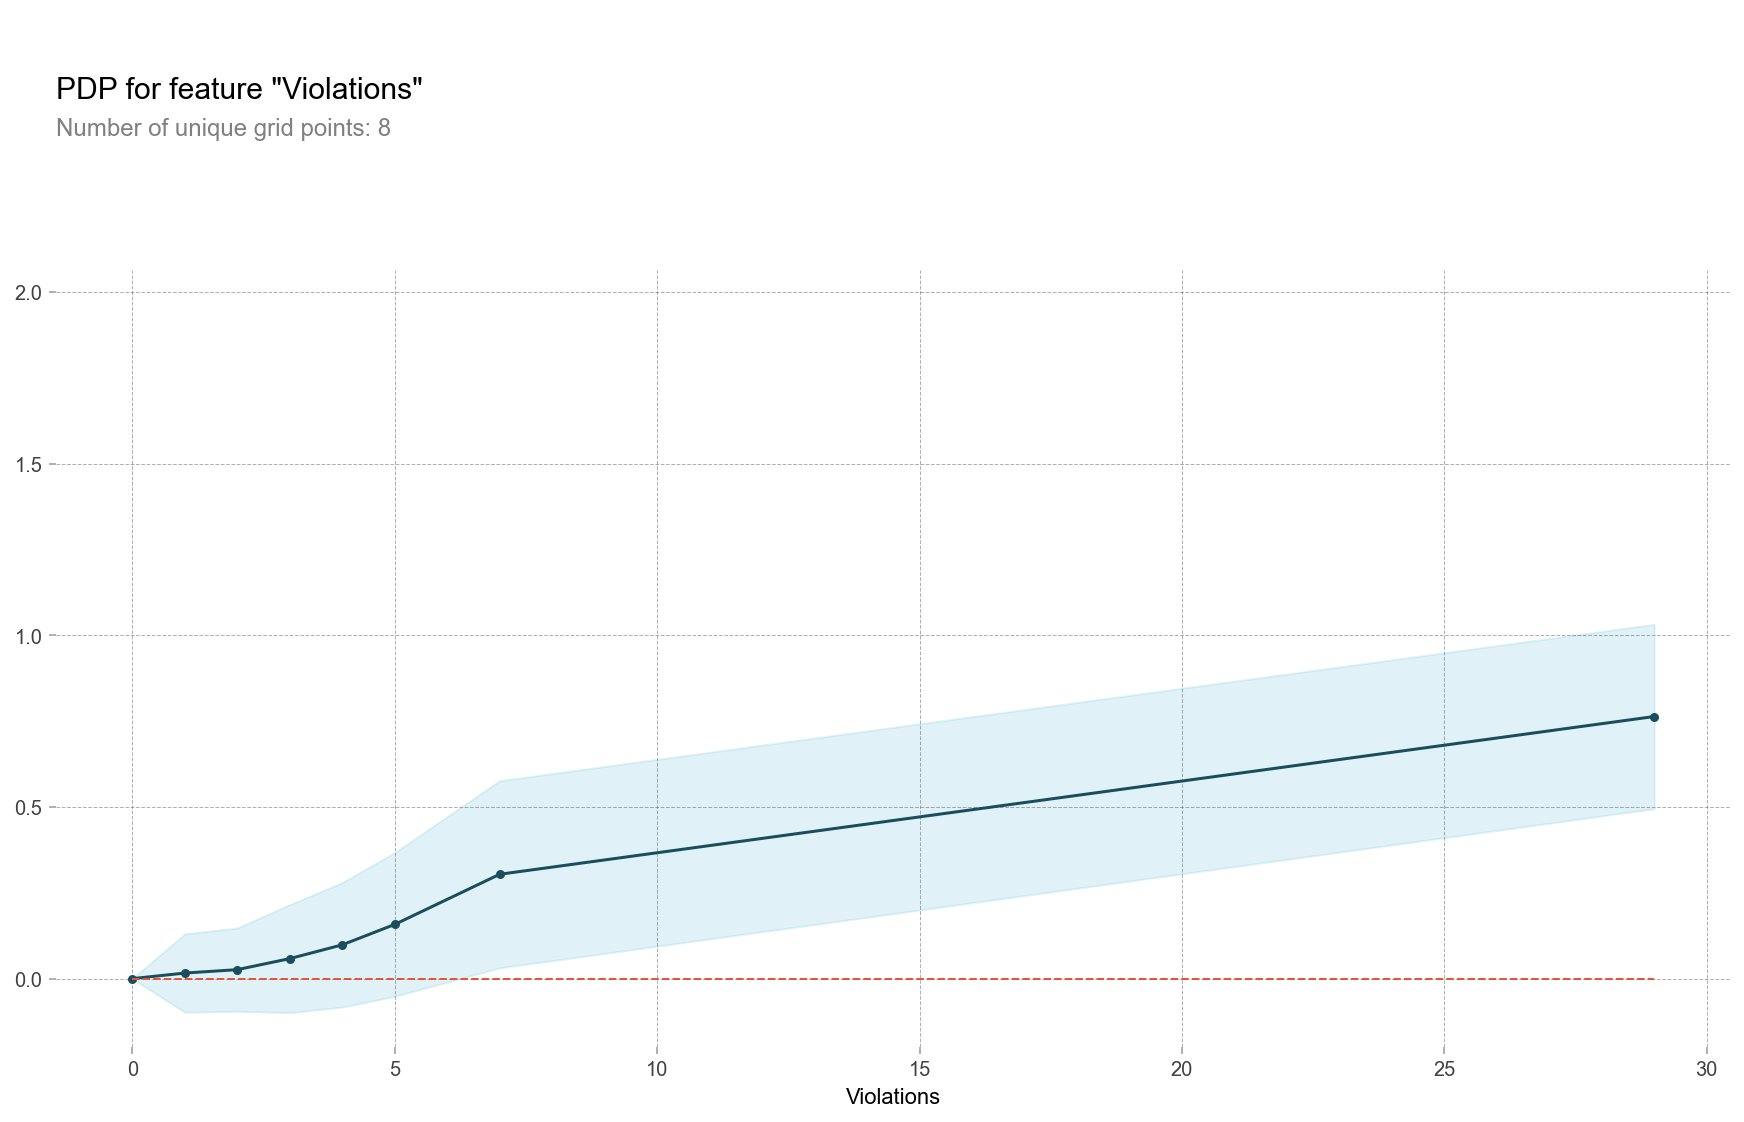

In [ ]:
# PDP Plot
plt.rcParams['figure.dpi'] = 144

X_test_df = pd.DataFrame(X_test_processed, columns=X_test.columns)

feature = 'Violations'  # Permutation 최상위

pdp_isolated = pdp_isolate(
    model=clf, 
    dataset=X_test_df, 
    model_features=X_test_df.columns, 
    feature=feature
)

pdp_plot(pdp_isolated, feature_name=feature);